# Poromechanics
In this tutorial will run a multiphysics simulation consisting of fully coupled single phase flow and mechanics.

In the [single phase flow tutorial](./single_phase_flow.ipynb), we introduced 
the concept of constructing a simulation model from several mixin classes using 
multiple inheritance in Python.
This approach allows us to keep the code modular and reuse some of the mixins in newly
defined models.

The benefits of this approach become clear when we want to define a multiphysics
model. To achieve that, it is usually enough to combine existing mixins properly.
We will illustrate that by assembling a poromechanics model from the mixins designed 
separately for the single phase flow model and the mechanics model. 

For this, we will first define two single physics models: one for mechanics and one for single phase flow. Then, we will combine them into one poromechanics model. 

Note that there is already a poromechanics model in PorePy, so what we demonstrate here in this tutorial is not building the entire model from scratch.
It is rather modifying two single physics models, and then combining them to modify the coupled model.

# Mechanics model

In the example problem, we will apply the Dirichlet boundary condition on each boundary
with the values:
* Nonzero on the northern boundary
* Zero elsewhere

Same as in the [single phase flow tutorial](./single_phase_flow.ipynb), we define 
a boundary condition mixin:

In [1]:
import porepy as pp
import numpy as np

class BoundaryConditionsMomentumBalance:
    def bc_type_mechanics(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        """Dirichlet boundary condition everywhere."""
        # Define boundary faces.
        boundary_faces = self.domain_boundary_sides(sd).all_bf
        bc = pp.BoundaryConditionVectorial(sd, boundary_faces, "dir")
        # Default internal BC is Neumann. We change to Dirichlet for the contact
        # problem. I.e., the mortar variable represents the displacement on the fracture
        # faces.
        bc.internal_to_dirichlet(sd)
        return bc

    def bc_values_mechanics(self, subdomains: list[pp.Grid]) -> pp.ad.DenseArray:
        """Setting the nonzero Dirichlet values on the north bound."""
        # s = super().bc_values_mechanics(subdomains)
        values = []
        for sd in subdomains:
            bc = np.zeros((sd.num_faces, self.nd))
            if sd.dim == self.nd:
                bounds = self.domain_boundary_sides(sd)
                bc[bounds.north, 1] = self.solid.convert_units(-0.2, "m")
            values.append(bc.ravel())
        return pp.wrap_as_ad_array(np.concatenate(values), "bc_vals_mechanics")

Now we can combine our mixin with the standard model `MomentumBalance`. This time we will not define the geometry manually, but instead use one of the pre-defined geometries provided by a mixin class.

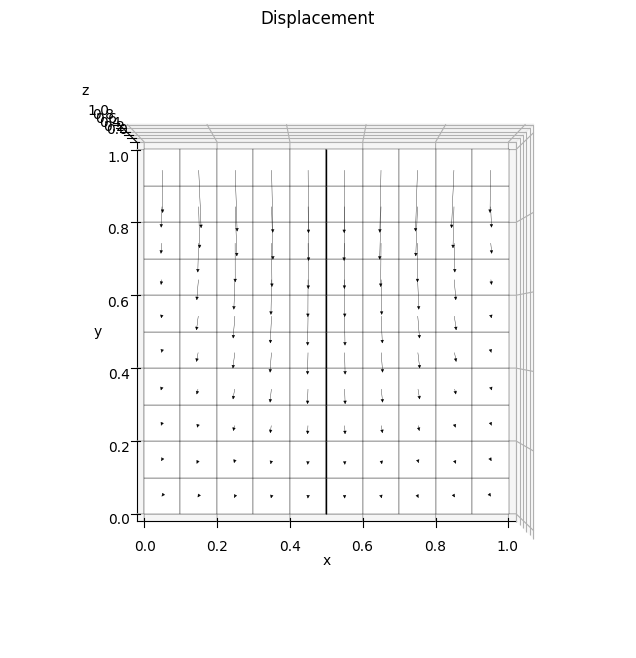

In [2]:
import porepy as pp

from porepy.applications.md_grids.model_geometries import (
    SquareDomainOrthogonalFractures,
)
from porepy.models.momentum_balance import MomentumBalance


class MomentumBalanceGeometryBC(
    BoundaryConditionsMomentumBalance,
    SquareDomainOrthogonalFractures,
    MomentumBalance,
):
    """Adding geometry and modified boundary conditions to the default model."""

    def meshing_arguments(self) -> dict:
        return {"cell_size": 0.1}


model = MomentumBalanceGeometryBC()
pp.run_time_dependent_model(model, {})
pp.plot_grid(
    model.mdg,
    vector_value=model.displacement_variable,
    rgb=[1, 1, 1],
    figsize=(10, 8),
    linewidth=0.25,
    title="Displacement",
)

# Single phase flow model

We have seen how to modify boundary condition and source for the single phase flow model
in the [earlier tutorial](./single_phase_flow.ipynb).
For this example we will repeat this process by setting the boundary condition:
* Zero Dirichlet on the north boundary
* Zero Neumann (no flux) everywhere else

And we will again set the fracture inlet source.

In [3]:
class PressureSourceBC:
    def bc_type_darcy(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign Dirichlet boundary condition to the north boundary and Neumann
        everywhere else.

        """
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.north, "dir")
        return bc

    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Assign fracture source."""
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []

        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells) * 0.1)

        external_sources = pp.wrap_as_ad_array(np.concatenate(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source

Again, we combine our mixin with the standard model and using the standard mixin geometry:

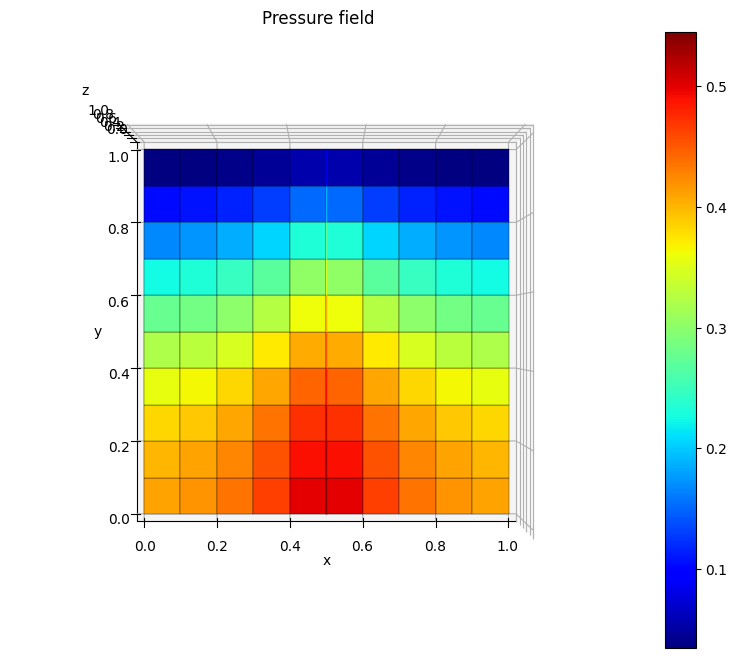

In [4]:
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class PoromechanicsSourceBC(
    PressureSourceBC,
    SquareDomainOrthogonalFractures,
    SinglePhaseFlow,
):
    """Adding geometry, boundary conditions and source to the default model."""

    def meshing_arguments(self) -> dict:
        return {"cell_size": 0.1}


model = PoromechanicsSourceBC()
pp.run_time_dependent_model(model, {})
pp.plot_grid(
    model.mdg,
    cell_value=model.pressure_variable,
    figsize=(10, 8),
    linewidth=0.25,
    title="Pressure field",
)

# Poromechanics

Now we are ready to combine our mixins in order to define a poromechanics problem.
Our problem will take the mechanics boundary conditions from the mechanics problem and the flow boundary condition and source from the flow problem.

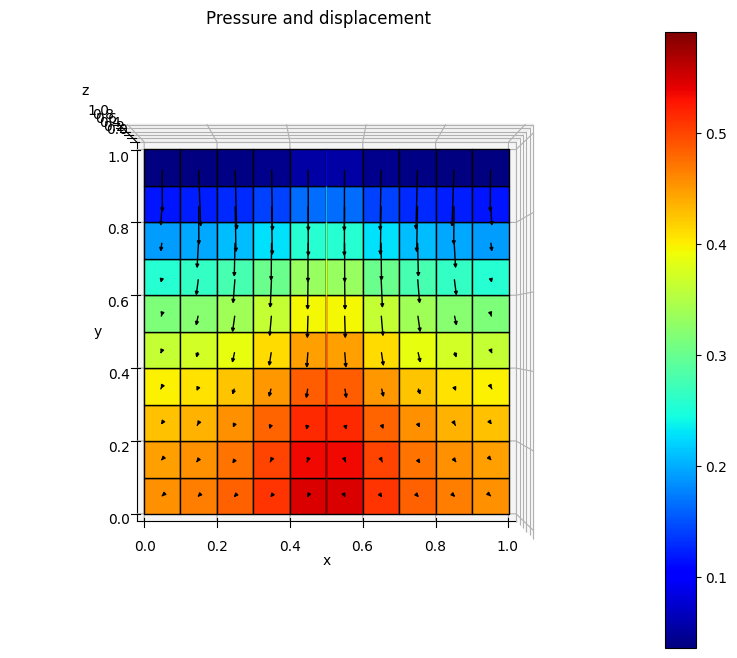

In [5]:
from porepy.models.poromechanics import Poromechanics


class PoromechanicsSourceBC(
    PressureSourceBC,
    BoundaryConditionsMomentumBalance,
    SquareDomainOrthogonalFractures,
    Poromechanics,
):
    """Adding geometry, boundary conditions and source to the default model."""

    def meshing_arguments(self) -> dict:
        return {"cell_size": 0.1}


model = PoromechanicsSourceBC()
pp.run_time_dependent_model(model, {})
pp.plot_grid(
    model.mdg,
    cell_value=model.pressure_variable,
    vector_value=model.displacement_variable,
    figsize=(10, 8),
    title="Pressure and displacement",
)

You may notice that the base class `Poromechanics` is defined itself by combining 
several mixins:

In [6]:
import inspect


print(inspect.getsource(Poromechanics))

class Poromechanics(  # type: ignore[misc]
    EquationsPoromechanics,
    VariablesPoromechanics,
    ConstitutiveLawsPoromechanics,
    BoundaryConditionsPoromechanics,
    SolutionStrategyPoromechanics,
    pp.ModelGeometry,
    pp.DataSavingMixin,
):
    """Class for the coupling of mass and momentum balance in a mixed-dimensional porous
    medium.

    """

    pass



Each of these mixins is a combination of the flow and the mechanics mixins. For instance:

In [7]:
from porepy.models.poromechanics import EquationsPoromechanics


print(inspect.getsource(EquationsPoromechanics))

class EquationsPoromechanics(
    mass.MassBalanceEquations,
    momentum.MomentumBalanceEquations,
):
    """Combines mass and momentum balance equations."""

    def set_equations(self):
        """Set the equations for the poromechanics problem.

        Call both parent classes' set_equations methods.

        """
        mass.MassBalanceEquations.set_equations(self)
        momentum.MomentumBalanceEquations.set_equations(self)



Thereby, the philosophy of multiple inheritance and mixins helps to modularize and reuse
 a significant part of code.

# What have we explored
We set up and ran a poromechanics simulation using the boundary conditions and source mixin classes originally designed for uncoupled problems.